In [1]:
######## snakemake preamble start (automatically inserted, do not edit) ########
library(methods)
Snakemake <- setClass(
    "Snakemake",
    slots = c(
        input = "list",
        output = "list",
        params = "list",
        wildcards = "list",
        threads = "numeric",
        log = "list",
        resources = "list",
        config = "list",
        rule = "character",
        bench_iteration = "numeric",
        scriptdir = "character",
        source = "function"
    )
)
snakemake <- Snakemake(
    input = list(),
    output = list('out/ipynb/compute_differential_methylation/dev_unpaired.xlsx', "xlsx" = 'out/ipynb/compute_differential_methylation/dev_unpaired.xlsx'),
    params = list(),
    wildcards = list('dev_unpaired', "design" = 'dev_unpaired'),
    threads = 2,
    log = list('out/ipynb/compute_differential_methylation/dev_unpaired.rds', 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb', "rds" = 'out/ipynb/compute_differential_methylation/dev_unpaired.rds', "notebook" = 'out/ipynb/compute_differential_methylation/dev_unpaired.r.ipynb'),
    resources = list('tmpdir', "tmpdir" = '/tmp'),
    config = list(),
    rule = 'ipynb_compute_differential_methylation',
    bench_iteration = as.numeric(NA),
    scriptdir = '/data/thymus/mw/mw-oncodiag/src/snakemake/rules/../../ipynb',
    source = function(...){
        wd <- getwd()
        setwd(snakemake@scriptdir)
        source(...)
        setwd(wd)
    }
)
setwd('/data/thymus/mw/mw-oncodiag');

######## snakemake preamble end #########


In [2]:
# start coding here

In [3]:
IRdisplay::display_markdown(
    sprintf(
"_Compute differential methylation %s_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

%s",
        snakemake@wildcards$design,
        format(Sys.Date(), "%Y-%m-%d")
    )
)

_Compute differential methylation dev_unpaired_

__Oncodiag project__

[Guillaume Charbonnier](mailto:gc.bioinfo@gmail.com)

2023-02-27

# Abstract

The aim of this analysis is to compute differential methylation between Tumor and Normal samples for the following design:

In [4]:
snakemake@wildcards$design

[1] "dev_unpaired"

# Methods

## Load dependencies

### Packages

In [5]:
if (!require("BiocManager", quietly = TRUE)) {
    install.packages(
        "BiocManager",
        quiet = TRUE
    )
}
packages <- c(
  # "data.table",
  # "dplyr",
  "openxlsx",
  "DT",
  # "methylSig",
  "DSS",
  "bsseq",
  "ChIPpeakAnno",
  # "ChIPseeker",
  # "methyAnalysis",
  "org.Hs.eg.db",
  "TxDb.Hsapiens.UCSC.hg19.knownGene",
  # "EnhancedVolcano",
  # "data.table",
  "ggpubr",
  # "ComplexHeatmap",
  "tidyr"
)
BiocManager::install(
    packages,
    update = FALSE,
    quiet = TRUE,
    Ncpus = parallel::detectCores()
)
invisible(
    lapply(
      packages,
      library,
      character.only = TRUE
    )
)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.16 (BiocManager 1.30.19), R 4.2.2 (2022-10-31)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'openxlsx' 'DT' 'DSS' 'bsseq' 'ChIPpeakAnno'
  'org.Hs.eg.db' 'TxDb.Hsapiens.UCSC.hg19.knownGene' 'ggpubr' 'tidyr'”
Loading required package: Biobase

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,


In [6]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS/LAPACK: /data/thymus/mw/mw-oncodiag/.snakemake/conda/02e263e4/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] tidyr_1.3.0                            
 [2] ggpubr_0.6.0                           
 [3] ggplot2_3.4.1                          
 [4] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [5] GenomicFeatures_1.50.2                 
 [6] org.Hs.eg.db_3.16.0                    
 [7] AnnotationDbi_1.60.0                   
 [8] 

In [7]:
set_plot_dim <- function(
    width = 16,
    height = 9
) {
    options(
        #jupyter.plot_scale=1,
        repr.plot.width = width,
        repr.plot.height = height
    )
}
set_plot_dim()

### Data

In [8]:
sample_metadata <- read.csv(
  "src/sample_sheets/all.csv"
)
if (grepl("^ODG_", snakemake@wildcards$design)) {
    patient <- as.integer(
        sub(
            "ODG_",
            "",
            snakemake@wildcards$design
        )
    )
    patient <- patient / 2 - 39
    sample_metadata <- sample_metadata[sample_metadata$patient_number == patient,]    
}
if (grepl("^all_", snakemake@wildcards$design)) {
    # Here I temporarily subset the sample sheets to already available samples
    suffix <- ".markdup.sorted_CpG.bedGraph"
    input_dir <- "out/nextflow/nfcore_methylseq/methyldackel/"
    files <- list.files(
        path = input_dir,
        pattern = suffix
    )
    samples <- sub(
        suffix,
        "",
        files
    )
    sample_metadata <- sample_metadata[sample_metadata$sample %in% samples,]
}
if (grepl("^dev_", snakemake@wildcards$design)) {
    sample_metadata <- sample_metadata[sample_metadata$patient_number %in% c(1,14,15),]
}
sample_metadata

,sample,fastq_1,fastq_2,patient_number,tissue
,<chr>,<chr>,<chr>,<int>,<chr>
1,ODG_080,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R2_001.fastq.gz,1,normal
2,ODG_081,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R2_001.fastq.gz,1,tumoral
27,ODG_106,inp/ONCODIAG/Novaseq_131222/fastq/ODG_106_S27_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_106_S27_R2_001.fastq.gz,14,normal
28,ODG_107,inp/ONCODIAG/Novaseq_131222/fastq/ODG_107_S28_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_107_S28_R2_001.fastq.gz,14,tumoral
29,ODG_108,inp/ONCODIAG/Novaseq_131222/fastq/ODG_108_S29_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_108_S29_R2_001.fastq.gz,15,normal
30,ODG_109,inp/ONCODIAG/Novaseq_131222/fastq/ODG_109_S30_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_109_S30_R2_001.fastq.gz,15,tumoral


In [9]:
# This will be used to load files with read.bismarck()
sample_metadata$bedGraph <- paste0(
    'out/nextflow/nfcore_methylseq/methyldackel/',
    sample_metadata$sample,
    '.markdup.sorted_CpG.bedGraph'
)

In [10]:
# row.names should be declared to be used as row.names of the BSseq object
# because DMLtest() uses these row.namesto select samples
row.names(sample_metadata) <- sample_metadata$sample
sample_metadata

,sample,fastq_1,fastq_2,patient_number,tissue,bedGraph
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
ODG_080,ODG_080,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_080_S1_R2_001.fastq.gz,1,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_080.markdup.sorted_CpG.bedGraph
ODG_081,ODG_081,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_081_S2_R2_001.fastq.gz,1,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_081.markdup.sorted_CpG.bedGraph
ODG_106,ODG_106,inp/ONCODIAG/Novaseq_131222/fastq/ODG_106_S27_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_106_S27_R2_001.fastq.gz,14,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_106.markdup.sorted_CpG.bedGraph
ODG_107,ODG_107,inp/ONCODIAG/Novaseq_131222/fastq/ODG_107_S28_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_107_S28_R2_001.fastq.gz,14,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_107.markdup.sorted_CpG.bedGraph
ODG_108,ODG_108,inp/ONCODIAG/Novaseq_131222/fastq/ODG_108_S29_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_108_S29_R2_001.fastq.gz,15,normal,out/nextflow/nfcore_methylseq/methyldackel/ODG_108.markdup.sorted_CpG.bedGraph
ODG_109,ODG_109,inp/ONCODIAG/Novaseq_131222/fastq/ODG_109_S30_R1_001.fastq.gz,inp/ONCODIAG/Novaseq_131222/fastq/ODG_109_S30_R2_001.fastq.gz,15,tumoral,out/nextflow/nfcore_methylseq/methyldackel/ODG_109.markdup.sorted_CpG.bedGraph


In [11]:
bsseq_stranded = bsseq::read.bismark(
    files = sample_metadata$bedGraph,
    colData = sample_metadata,
    rmZeroCov = FALSE,
    strandCollapse = FALSE,
    BACKEND = "HDF5Array",
    dir = sub(
        ".rds",
        "hdf5a",
        snakemake@log$rds
    ),
    replace = TRUE
)
bsseq_stranded

Loading required package: DelayedArray

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


The following object is masked from 'package:S4Vectors':

    expand



Attaching package: 'DelayedArray'


The following objects are masked from 'package:base':

    apply, rowsum, scale, sweep


Loading required package: rhdf5


Attaching package: 'HDF5Array'


The following object is masked from 'package:rhdf5':

    h5ls




An object of type 'BSseq' with
  55332068 methylation loci
  6 samples
has not been smoothed
Some assays are HDF5Array-backed

In [12]:
sampleNames(bsseq_stranded)

[1] "ODG_080" "ODG_081" "ODG_106" "ODG_107" "ODG_108" "ODG_109"

In [13]:
which(grepl("normal", pData(bsseq_stranded)$tissue))

[1] 1 3 5

In [14]:
which(grepl("tumoral", pData(bsseq_stranded)$tissue))

[1] 2 4 6

## Compute differential methylation

In [15]:
if (file.exists(snakemake@log$rds)) {
    dml_res <- readRDS(snakemake@log$rds)
} else {
    if (grepl("_paired", snakemake@wildcards$design)) {
        design_df <- data.frame(colData(bsseq_stranded)[,c("tissue", "patient_number")])
        design_df$patient_number <- factor(design_df$patient_number)
        design_df$tissue <- factor(design_df$tissue)
        dml_fit = DMLfit.multiFactor(
            bsseq_stranded,
            design = design_df,
            formula = ~ tissue + patient_number,
            smoothing = TRUE
        )
        dml_res = DMLtest.multiFactor(
            dml_fit,
            term="tissue"
        )
    } else {    
        dml_res = DMLtest(
          bsseq_stranded,
          group1 = which(grepl("tumoral", pData(bsseq_stranded)$tissue)),
          group2 = which(grepl("normal", pData(bsseq_stranded)$tissue)), 
          # Was working but through error with new conda env
          # ncores = parallel::detectCores(),
          smoothing = TRUE
        )
    }
    saveRDS(
        object = dml_res, 
        file = snakemake@log$rds
    )
}

if (grepl("_paired", snakemake@wildcards$design)) {
    # Delta threshold has to be set to 0 for general model testing
    delta_threshold <- 0
} else {
    delta_threshold <- 0.1
}

In [16]:
dml_signif_res = callDML(
    dml_res,
    delta = delta_threshold,
    p.threshold = 0.001
)
dim(dml_signif_res)

[1] 1624667      12

In [17]:
dmr_signif_res = callDMR(
    dml_res,
    delta = delta_threshold,
    p.threshold = 0.05
)
dim(dmr_signif_res)

[1] 226776      9

## Annotate differential regions

In [18]:
# # txdb <- TxDb.Hsapiens.UCSC.hg19.knownGene
# peakAnno <- annotatePeak(
#     dml_res[1:4,], 
#     tssRegion = c(-3000, 3000),
#     TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene,
#     annoDb = "org.Hs.eg.db"
# )
# peakAnno

In [19]:
TxDb.Hsapiens.UCSC.hg19.knownGene

TxDb object:
# Db type: TxDb
# Supporting package: GenomicFeatures
# Data source: UCSC
# Genome: hg19
# Organism: Homo sapiens
# Taxonomy ID: 9606
# UCSC Table: knownGene
# Resource URL: http://genome.ucsc.edu/
# Type of Gene ID: Entrez Gene ID
# Full dataset: yes
# miRBase build ID: GRCh37
# transcript_nrow: 82960
# exon_nrow: 289969
# cds_nrow: 237533
# Db created by: GenomicFeatures package from Bioconductor
# Creation time: 2015-10-07 18:11:28 +0000 (Wed, 07 Oct 2015)
# GenomicFeatures version at creation time: 1.21.30
# RSQLite version at creation time: 1.0.0
# DBSCHEMAVERSION: 1.1

In [20]:
# Annotate DMR
annoData <- toGRanges(
    TxDb.Hsapiens.UCSC.hg19.knownGene,
    feature = "gene"
)
annoData

  403 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.



GRanges object with 23056 ranges and 0 metadata columns:
        seqnames              ranges strand
           <Rle>           <IRanges>  <Rle>
      1    chr19   58858172-58874214      -
     10     chr8   18248755-18258723      +
    100    chr20   43248163-43280376      -
   1000    chr18   25530930-25757445      -
  10000     chr1 243651535-244006886      -
    ...      ...                 ...    ...
   9991     chr9 114979995-115095944      -
   9992    chr21   35736323-35743440      +
   9993    chr22   19023795-19109967      -
   9994     chr6   90539619-90584155      +
   9997    chr22   50961997-50964905      -
  -------
  seqinfo: 93 sequences (1 circular) from hg19 genome

In [21]:
dmr_signif_gr <- GRanges(
    seqnames = dmr_signif_res$chr,
    ranges = IRanges(
        start = dmr_signif_res$start,
        end = dmr_signif_res$end
    ),
    mcols = dmr_signif_res[,!colnames(dmr_signif_res) %in% c("chr", "start", "end")]
)

In [22]:
dmr_signif_annot_gr <- annotatePeakInBatch(
    dmr_signif_gr,
    AnnotationData = annoData
)
dmr_signif_annot_gr

Warning message in (function (seqlevels, genome, new_style) :
"cannot switch some hg19's seqlevels from UCSC to NCBI style"


GRanges object with 227337 ranges and 15 metadata columns:
                    seqnames              ranges strand | mcols.length
                       <Rle>           <IRanges>  <Rle> |    <numeric>
      X000001.64118       17   80038106-80054660      * |        16555
      X000002.10265       16   54965817-54973131      * |         7315
       X000003.6656       13 112719943-112723820      * |         3878
     X000004.389813        9 139738642-139741910      * |         3269
  X000005.100423031       19     2251168-2254192      * |         3025
                ...      ...                 ...    ... .          ...
     X226772.139189        X   50331974-50332748      * |          775
       X226773.4087       18   45212621-45212903      * |          283
     X226774.286514        X   25603442-25604069      * |          628
      X226775.90316        X   89456893-89457268      * |          376
       X226776.8660       13 110569391-110570036      * |          646
                  

In [23]:
dmr_signif_annot_gr <- addGeneIDs(
    dmr_signif_annot_gr,
    orgAnn="org.Hs.eg.db",
    feature_id_type = "entrez_id",
    IDs2Add=c("symbol")
)
dmr_signif_annot_gr

GRanges object with 227337 ranges and 16 metadata columns:
                    seqnames              ranges strand | mcols.length
                       <Rle>           <IRanges>  <Rle> |    <numeric>
      X000001.64118       17   80038106-80054660      * |        16555
      X000002.10265       16   54965817-54973131      * |         7315
       X000003.6656       13 112719943-112723820      * |         3878
     X000004.389813        9 139738642-139741910      * |         3269
  X000005.100423031       19     2251168-2254192      * |         3025
                ...      ...                 ...    ... .          ...
     X226772.139189        X   50331974-50332748      * |          775
       X226773.4087       18   45212621-45212903      * |          283
     X226774.286514        X   25603442-25604069      * |          628
      X226775.90316        X   89456893-89457268      * |          376
       X226776.8660       13 110569391-110570036      * |          646
                  

In [24]:
mcols(dmr_signif_annot_gr)$peak <- NULL
mcols(dmr_signif_annot_gr)$feature <- NULL
mcols(dmr_signif_annot_gr)$distancetoFeature <- NULL
mcols(dmr_signif_annot_gr)$shortestDistance <- NULL
mcols(dmr_signif_annot_gr)$fromOverlappingOrNearest <- NULL

colnames(mcols(dmr_signif_annot_gr)) <- sub(
    "mcols\\.",
    "region_",
    colnames(mcols(dmr_signif_annot_gr))
)

colnames(mcols(dmr_signif_annot_gr)) <- sub(
    "start_position",
    "gene_start",
    colnames(mcols(dmr_signif_annot_gr))
)
colnames(mcols(dmr_signif_annot_gr)) <- sub(
    "end_position",
    "gene_end",
    colnames(mcols(dmr_signif_annot_gr))
)
colnames(mcols(dmr_signif_annot_gr)) <- sub(
    "feature_strand",
    "gene_strand",
    colnames(mcols(dmr_signif_annot_gr))
)
colnames(mcols(dmr_signif_annot_gr)) <- sub(
    "insideFeature",
    "region_relative_to_gene",
    colnames(mcols(dmr_signif_annot_gr))
)
colnames(mcols(dmr_signif_annot_gr)) 

[1] "region_length"           "region_nCG"             
 [3] "region_meanMethy1"       "region_meanMethy2"      
 [5] "region_diff.Methy"       "region_areaStat"        
 [7] "gene_start"              "gene_end"               
 [9] "gene_strand"             "region_relative_to_gene"
[11] "symbol"

In [25]:
dmr_signif_annot_gr

GRanges object with 227337 ranges and 11 metadata columns:
                    seqnames              ranges strand | region_length
                       <Rle>           <IRanges>  <Rle> |     <numeric>
      X000001.64118       17   80038106-80054660      * |         16555
      X000002.10265       16   54965817-54973131      * |          7315
       X000003.6656       13 112719943-112723820      * |          3878
     X000004.389813        9 139738642-139741910      * |          3269
  X000005.100423031       19     2251168-2254192      * |          3025
                ...      ...                 ...    ... .           ...
     X226772.139189        X   50331974-50332748      * |           775
       X226773.4087       18   45212621-45212903      * |           283
     X226774.286514        X   25603442-25604069      * |           628
      X226775.90316        X   89456893-89457268      * |           376
       X226776.8660       13 110569391-110570036      * |           646
     

In [26]:
head(dml_signif_res)

,chr,pos,mu1,mu2,diff,diff.se,stat,phi1,phi2,pval,fdr,postprob.overThreshold
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8539,1,846085,0.6589844,0.3553443,0.3036400,0.02448246,12.40235,0.21000766,0.31703044,2.537757e-35,5.479918e-33,1
8557,1,846353,0.7777273,0.4344780,0.3432492,0.02472833,13.88081,0.06592711,0.07305760,8.280577e-44,2.815198e-41,1
8558,1,846354,0.7777273,0.4344780,0.3432492,0.02698350,12.72071,0.10276038,0.09128615,4.537133e-37,1.076280e-34,1
8559,1,846395,0.7766381,0.4229948,0.3536433,0.02377640,14.87371,0.07445022,0.06282702,4.882893e-50,2.287165e-47,1
8560,1,846396,0.7766381,0.4229948,0.3536433,0.02871727,12.31465,0.07394468,0.05025859,7.553759e-35,1.589819e-32,1
8561,1,846425,0.7871325,0.4239335,0.3631991,0.02585777,14.04603,0.12069416,0.06241339,8.147396e-45,2.918855e-42,1


In [27]:
if (grepl("_unpaired", snakemake@wildcards$design)) {
    # findOVerlap between dmr and dml here to extract top discriminating CG
    dml_signif_gr <- GRanges(
        seqnames = dml_signif_res$chr,
        ranges = IRanges(
            start = dml_signif_res$pos,
            end = dml_signif_res$pos + 1
        ),
        mcols = dml_signif_res[,!colnames(dml_signif_res) %in% c("chr", "start", "end")]
    )

    # Find overlaps between gr1 and gr2
    overlaps <- findOverlaps(
        dml_signif_gr,
        dmr_signif_annot_gr
    )
    
    # Get the indices of overlapping regions in gr1 and gr2
    overlaps_in_dml_signif_gr <- queryHits(overlaps)
    overlaps_in_dmr_signif_annot_gr <- subjectHits(overlaps)
    
    # Extract the overlapping regions from gr1 and gr2
    overlapping_regions_in_dml_signif_gr <- dml_signif_gr[overlaps_in_dml_signif_gr]
    overlapping_regions_in_dmr_signif_annot_gr <- dmr_signif_annot_gr[overlaps_in_dmr_signif_annot_gr]
    
}

In [28]:
if (grepl("_unpaired", snakemake@wildcards$design)) {
    overlapping_regions_in_dml_signif_df <- data.frame(overlapping_regions_in_dml_signif_gr)
    colnames(overlapping_regions_in_dml_signif_df) <- sub(
        "mcols.",
        "cg_",
        colnames(overlapping_regions_in_dml_signif_df)
    )
    colnames(overlapping_regions_in_dml_signif_df) <- sub(
        "seqnames",
        "cg_chr",
        colnames(overlapping_regions_in_dml_signif_df)
    )
    overlapping_regions_in_dml_signif_df$start <- NULL
    overlapping_regions_in_dml_signif_df$end <- NULL
    overlapping_regions_in_dml_signif_df$strand <- NULL
    overlapping_regions_in_dml_signif_df$width <- NULL
    overlapping_regions_in_dml_signif_df$cg_diff.se <- NULL
    overlapping_regions_in_dml_signif_df$cg_stat <- NULL
    overlapping_regions_in_dml_signif_df$cg_phi1 <- NULL
    overlapping_regions_in_dml_signif_df$cg_phi2 <- NULL
    overlapping_regions_in_dml_signif_df$cg_postprob.overThreshold <- NULL
    colnames(overlapping_regions_in_dml_signif_df)
}

[1] "cg_chr"  "cg_pos"  "cg_mu1"  "cg_mu2"  "cg_diff" "cg_pval" "cg_fdr"

In [29]:
if (grepl("_unpaired", snakemake@wildcards$design)) {
    merge_dml_dmr_signif <- cbind(
        data.frame(overlapping_regions_in_dmr_signif_annot_gr),
        overlapping_regions_in_dml_signif_df
    )
    colnames(merge_dml_dmr_signif) <- sub(
        "mcols.",
        "",
        colnames(merge_dml_dmr_signif)
    )

    merge_dml_dmr_signif <- merge_dml_dmr_signif[order(-abs(merge_dml_dmr_signif$cg_diff)),]
    head(merge_dml_dmr_signif)
}

,seqnames,start,end,width,strand,region_length,region_nCG,region_meanMethy1,region_meanMethy2,region_diff.Methy,⋯,gene_strand,region_relative_to_gene,symbol,cg_chr,cg_pos,cg_mu1,cg_mu2,cg_diff,cg_pval,cg_fdr
,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
283417,2,137576022,137576685,664,*,664,10,0.4773263,0.8835023,-0.4061760,⋯,+,inside,THSD7B,2,137576022,0.2487971,0.9770900,-0.7282929,5.062759e-21,4.833831e-19
478501,2,137576022,137576685,664,*,664,10,0.4773263,0.8835023,-0.4061760,⋯,+,inside,THSD7B,2,137576023,0.2487971,0.9770900,-0.7282929,1.692727e-13,9.339605e-12
294579,10,96613370,96615354,1985,*,1985,14,0.5692894,0.8836058,-0.3143163,⋯,+,upstream,CYP2C9,10,96615354,0.1947525,0.9026179,-0.7078653,1.328085e-20,1.235156e-18
363051,10,96613370,96615354,1985,*,1985,14,0.5692894,0.8836058,-0.3143163,⋯,+,upstream,CYP2C9,10,96615353,0.1947525,0.9026179,-0.7078653,1.730255e-17,1.309369e-15
413177,3,192875686,192876063,378,*,378,5,0.3511177,0.8266226,-0.4755049,⋯,+,upstream,PLAAT1,3,192876062,0.1816746,0.8888607,-0.7071861,1.279915e-15,8.445845e-14
815281,3,192875686,192876063,378,*,378,5,0.3511177,0.8266226,-0.4755049,⋯,+,upstream,PLAAT1,3,192876063,0.1816746,0.8888607,-0.7071861,6.989164e-08,1.818679e-06


In [30]:
if (grepl("_unpaired", snakemake@wildcards$design)) {
    # Only keep the CG with the highest difference for each region
    top_dml_dmr_signif <- merge_dml_dmr_signif[
        !duplicated(
            merge_dml_dmr_signif[
                ,
                c(
                    "seqnames",
                    "start",
                    "end"
                )
            ]
        ),
    ]
    top_dml_dmr_signif <- top_dml_dmr_signif[
        order(
            top_dml_dmr_signif$cg_pval,
            -abs(top_dml_dmr_signif$cg_diff)),]
    top_dml_dmr_signif <- rename(
        top_dml_dmr_signif,
        "seqnames" = "region_chr",
        "start" = "region_start",
        "end" = "region_end",
        "width" = "region_width"
    )
    top_dml_dmr_signif$strand <- NULL
    colnames(top_dml_dmr_signif)
}

[1] "region_chr"              "region_start"           
 [3] "region_end"              "region_width"           
 [5] "region_length"           "region_nCG"             
 [7] "region_meanMethy1"       "region_meanMethy2"      
 [9] "region_diff.Methy"       "region_areaStat"        
[11] "gene_start"              "gene_end"               
[13] "gene_strand"             "region_relative_to_gene"
[15] "symbol"                  "cg_chr"                 
[17] "cg_pos"                  "cg_mu1"                 
[19] "cg_mu2"                  "cg_diff"                
[21] "cg_pval"                 "cg_fdr"

In [31]:
# If design is unpaired, output the special object containing infos on the top DM CG for each DMR.
if (grepl("_unpaired", snakemake@wildcards$design)) {
    write.xlsx(
        x = top_dml_dmr_signif,
        file = snakemake@output$xlsx,
        overwrite = TRUE
    )
} else {
    write.xlsx(
        x = dmr_signif_annot_gr,
        file = snakemake@output$xlsx,
        overwrite = TRUE
    )
}

# Results

- Differentially methylated regions are available as [xlsx here](https://gcbio.info/reports/oncodiag_AHcsLfMNbisysKg74ati3uE7WEh0AMVfYXzTJEZVuvhOLUhW99/mw-oncodiag-data/out/ipynb/compute_differential_methylation/).
- Each locus can be visually inspected using [this genome browser](https://gcbio.info/reports/oncodiag_AHcsLfMNbisysKg74ati3uE7WEh0AMVfYXzTJEZVuvhOLUhW99/mw-oncodiag/src/igv.js/test_methylation_bigwig_from_bedgraph.html)
- You can easily copy the cells containing chr+start+end in the xlsx and paste it in the genome browser search field.

In [32]:
# p <- ggsummarystats(
#     dmr_signif_res,
#     y = c("length", "diff.Methy")
# )
# p

## Properties of the differentially methylated regions

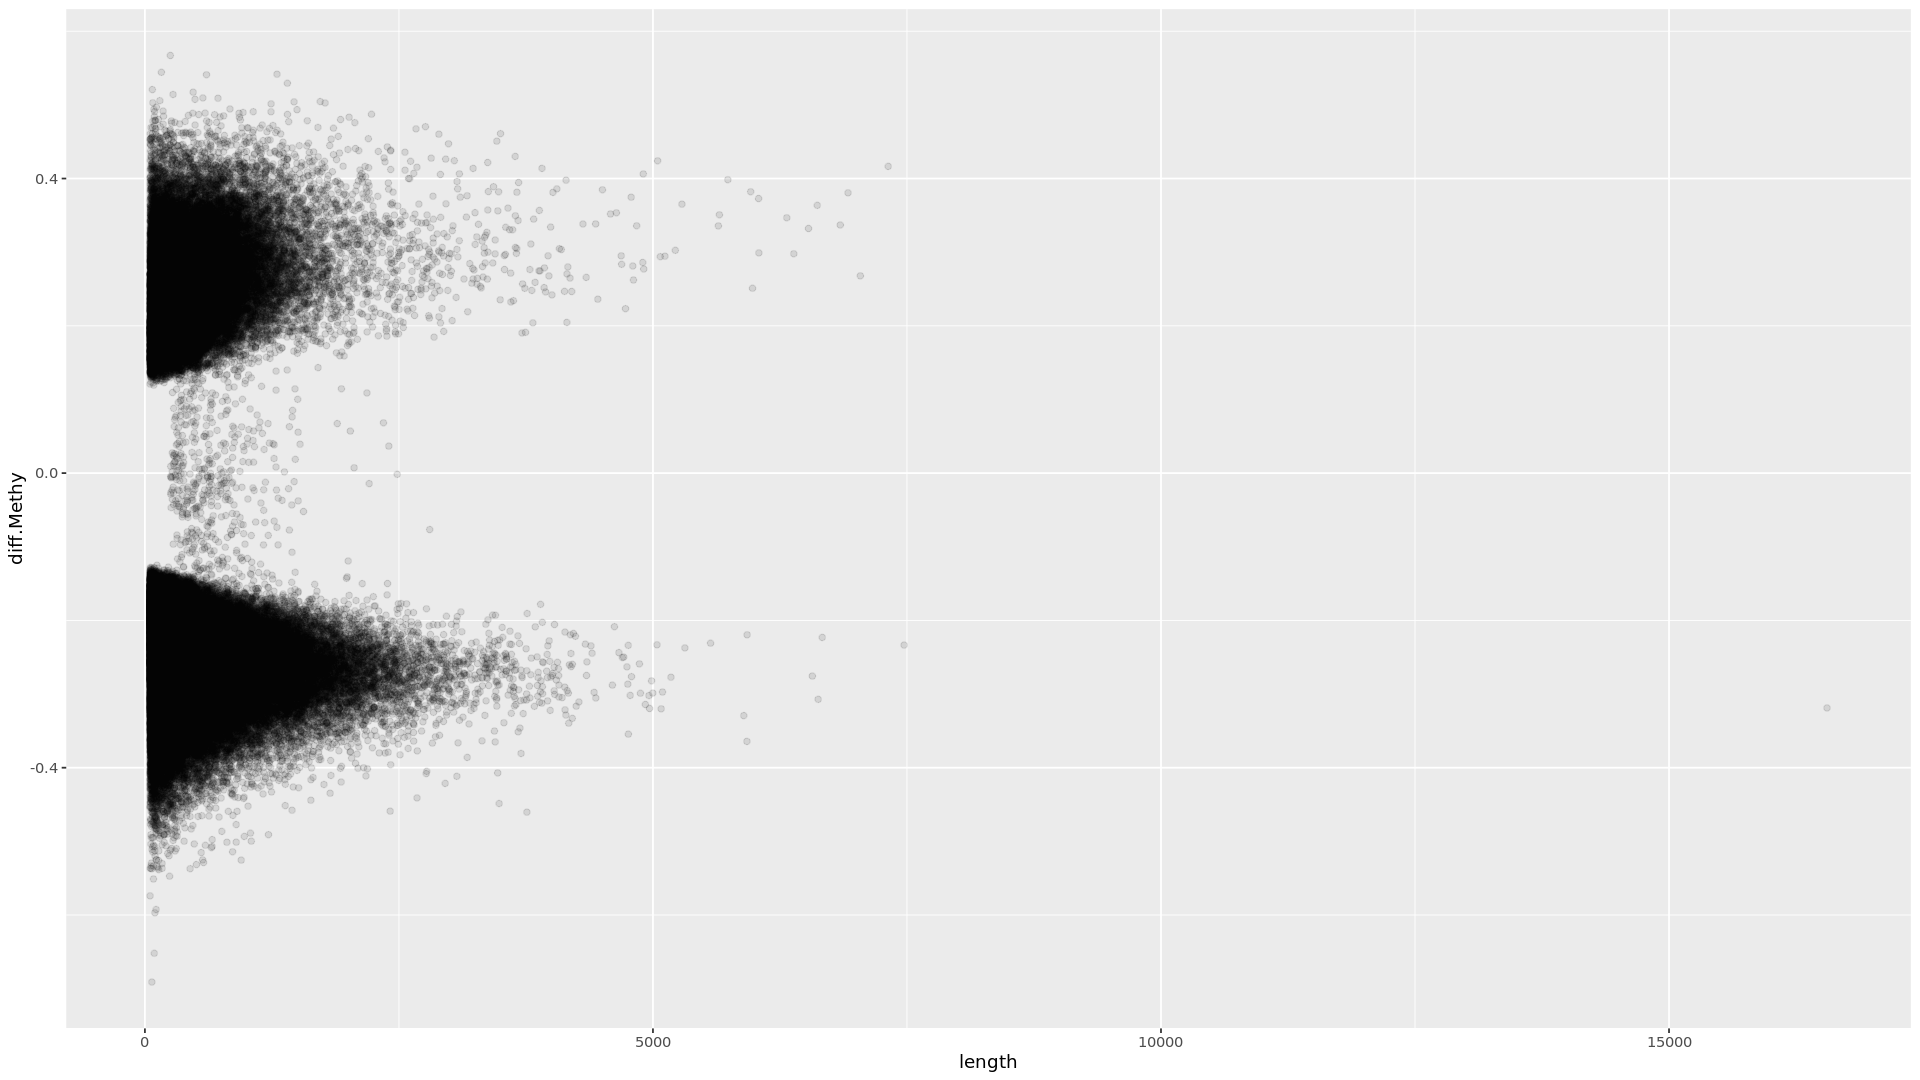

In [33]:
p <- ggplot(
    dmr_signif_res,
    aes(
        x = length,
        y = diff.Methy
    )
)
p <- p + geom_point(alpha=0.1)
p

## Focus on the key genes of interest

If any differentially methylated region is associated with the key genes of interest, they are listed below.

In [39]:
data.frame(
    dmr_signif_annot_gr[
        dmr_signif_annot_gr$symbol %in% c(
            "SLC22A3",
            "ANXA3",
            "CUX2"
        ),
        c(
            #"seqnames", "start", "end", 
            "region_diff.Methy", 
            "region_relative_to_gene",
            "symbol"
        )
    ]
)

seqnames,start,end,width,strand,region_diff.Methy,region_relative_to_gene,symbol
<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>
12,111536059,111537297,1239,*,0.2847670,inside,CUX2
12,111618609,111619502,894,*,0.2787974,inside,CUX2
12,111501178,111501764,587,*,0.2911073,inside,CUX2
12,111631841,111632579,739,*,0.2324777,inside,CUX2
12,111638885,111639444,560,*,0.2071457,inside,CUX2
6,160770788,160771536,749,*,-0.2500786,inside,SLC22A3
12,111581066,111581286,221,*,0.1942836,inside,CUX2
6,160778350,160778639,290,*,0.2378321,inside,SLC22A3
6,160799455,160800030,576,*,0.2383986,inside,SLC22A3


## Focus on top differentially methylated regions

In [ ]:
if (grepl("^ODG_", snakemake@wildcards$design)) {
    showOneDMR(
        dmr_signif_res[1,],
        bsseq_stranded[,1:2]
    )
} else {
    showOneDMR(
        dmr_signif_res[1,],
        bsseq_stranded[,1:min(6, ncol(bsseq_stranded))]
    )
}

In [ ]:
if (ncol(bsseq_stranded) > 6) {
    showOneDMR(
        dmr_signif_res[1,],
        bsseq_stranded[,7:min(12, ncol(bsseq_stranded))]
    )
} else {
    print("This slide is empty in the current design")
}

In [ ]:
if (ncol(bsseq_stranded) > 12) {
    showOneDMR(
        dmr_signif_res[1,],
        bsseq_stranded[,13:min(18, ncol(bsseq_stranded))]
    )
} else {
    print("This slide is empty in the current design")
}